### IE801 물류관리 HW2

- 이름 : 이강훈
- 학번 : 20203421

In [33]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

import gurobipy as gp
from gurobipy import GRB

### Problem 1 : Generate TSP instances of n=20, 50, 100 randomly.

In [34]:
def generate_instance(num_nodes):
    x = np.random.randint(100, size=num_nodes)
    y = np.random.randint(100, size=num_nodes)
    return x, y

In [59]:
def visualize_points(x, y, title=None, tour=None):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
        
    plt.show()
    plt.close('all')

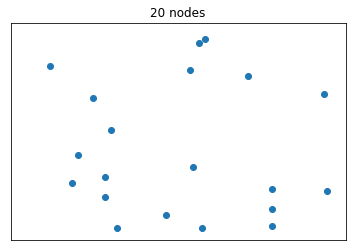

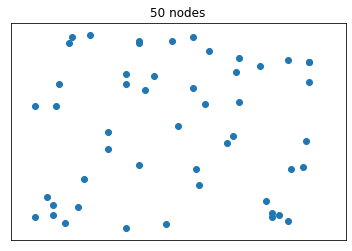

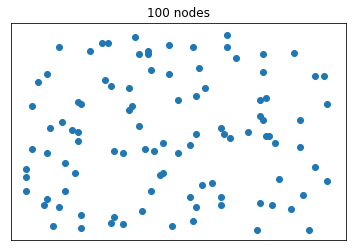

In [36]:
x, y = generate_instance(20)
visualize_points(x, y, "20 nodes")

x, y = generate_instance(50)
visualize_points(x, y, "50 nodes")

x, y = generate_instance(100)
visualize_points(x, y, "100 nodes")

### Problem 2 : Solve the problems using Gurobi and lazy constraints.

<!-- ![nn](./Images/HW2_image1.png) -->

Reference : https://www.gurobi.com/documentation/9.1/examples/tsp_py.html

In [37]:
def get_cost(x, y):
    
    x_ = x.copy().reshape(-1, 1)
    y_ = y.copy().reshape(-1, 1)
    cost = np.sqrt((x - x_) ** 2 + (y - y_) ** 2)
    
    return cost

In [71]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n:
            # add subtour elimination constr. for every pair of cities in tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2)) <= len(tour)-1)

In [72]:
# Given a tuplelist of edges, find the shortest subtour
def subtour(edges):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [113]:
from itertools import combinations

num_nodes = 20
n = num_nodes

random.seed(1)
x, y = generate_instance(num_nodes)
cost = get_cost(x, y)

model = gp.Model()
variables = gp.tupledict()

for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            variables[i, j] = model.addVar(obj=cost[i][j], vtype=GRB.BINARY)

for i, j in variables.keys():
    variables[j, i] = variables[i, j]

for i in range(n):
    temp_list = list(range(n))
    temp_list.pop(i)
    model.addConstr(sum(variables[i, j] for j in temp_list) == 2)
#     model.addConstr(sum(variables[i, j] for j in temp_list) == 1)
#     model.addConstr(sum(variables[j, i] for j in temp_list) == 1)

model._vars = variables
model.Params.lazyConstraints = 1
model.optimize(subtourelim)

vals = model.getAttr('x', variables)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

tour = subtour(selected)
assert len(tour) == num_nodes

print('')
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g' % model.objVal)
print('')

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 20 rows, 380 columns and 380 nonzeros
Model fingerprint: 0x76d032b9
Variable types: 0 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 20 rows, 380 columns, 380 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 3.340961e+02, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  334.09614    0    8          -  334.09614      -     -    0s
     0     0  343.07066    0    6          -  343.07066   

In [114]:
x, y

(array([27, 69,  3, 17,  8, 59, 77, 76, 83, 60, 26, 28, 22, 98, 35, 62, 76,
        18, 22, 96]),
 array([ 0, 35, 29, 42, 10, 80, 91, 60, 55, 40,  9,  0, 79, 32,  7, 32, 53,
        85,  7, 81]))

In [115]:
print(np.array(tour))
print(x[np.array(tour)])

[ 0 10 18  4  2  3 12 17  5  6 19  7 16  8 13  1  9 15 14 11]
[27 26 22  8  3 17 22 18 59 77 96 76 76 83 98 69 60 62 35 28]


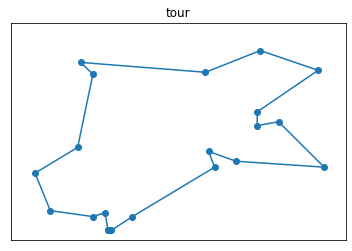

In [116]:
tour = tour + tour[:1]
visualize_points(x, y, 'tour', np.array(tour))